In [47]:
import torch
from torch import nn, optim 
import torch.nn.functional as F
from torchvision import datasets,transforms,models
from collections import OrderedDict
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

In [48]:
data_directory = "../input/pothole-and-plain-rode-images/My Dataset"
tr_train = transforms.Compose([transforms.RandomRotation(30),
                               transforms.RandomResizedCrop(224),
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406],
                                                   [0.229, 0.224, 0.225])])
tr_test = transforms.Compose([
                              transforms.Resize(255),
                              transforms.CenterCrop(224),
                              transforms.ToTensor(),
                              transforms.Normalize([0.485, 0.456, 0.406],
                                                 [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(data_directory+'/train',transform = tr_train)
test_data = datasets.ImageFolder(data_directory+'/test',transform = tr_test)
trainloader = torch.utils.data.DataLoader(train_data,batch_size=32,shuffle=True)
testloader = torch.utils.data.DataLoader(test_data,batch_size=32)

In [49]:
model = models.resnet101(pretrained = True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [50]:
for parameter in model.parameters():
    parameter.requiers_grad = False
fc = nn.Sequential(OrderedDict([
    ("layer1", nn.Linear(2048,1250)),
    ("relu",nn.ReLU()),
    ("layer2",nn.Linear(1250,2)),
    ("output",nn.LogSoftmax(dim=1))
]))
model.fc = fc 

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(),lr=0.002)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [52]:
epochs = 1
steps = 0
running_loss = 0
every = 4
train_losses, test_losses = [],[]
for e in range(epochs):
    for inputs,labels in trainloader:
        steps +=1
        inputs,labels = inputs.to(device),labels.to(device)
        optimizer.zero_grad()
        log_pro = model.forward(inputs)
        loss = criterion(log_pro,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % every ==0:
            test_loss =0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs,labels in testloader:
                    inputs,labels = inputs.to(device),labels.to(device)
                    log_pro = model.forward(inputs)
                    batch_loss = criterion(log_pro,labels)
                    test_loss+= batch_loss.item()
                    
                    pro = torch.exp(log_pro)
                    top_pro,top_cls = pro.topk(1,dim=1)
                    equality = top_cls == labels.view(*top_cls.shape)
                    accuracy += torch.mean(equality.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))
            print(f"Epoch {e+1}/{epochs}.. "
                  f"Train loss: {running_loss/every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/1.. Train loss: 1.808.. Test loss: 4.035.. Test accuracy: 0.500
Epoch 1/1.. Train loss: 2.518.. Test loss: 1.651.. Test accuracy: 0.562
Epoch 1/1.. Train loss: 0.995.. Test loss: 1.375.. Test accuracy: 0.562
Epoch 1/1.. Train loss: 0.879.. Test loss: 0.724.. Test accuracy: 0.688
Epoch 1/1.. Train loss: 0.774.. Test loss: 0.193.. Test accuracy: 0.938


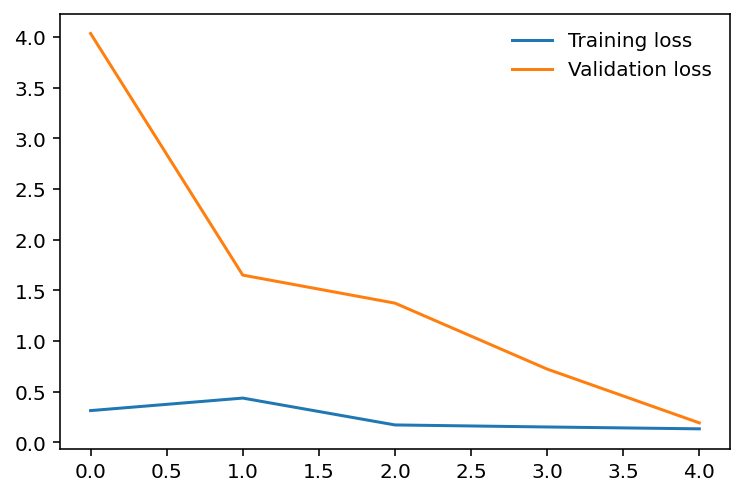

In [53]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)